In [1]:
!pip install -q transformers datasets accelerate scikit-learn torch tqdm indic-transliteration


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

# Install + Imports

In [7]:
import os, random, math, numpy as np, pandas as pd, torch
from dataclasses import dataclass
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from datasets import Dataset, DatasetDict

torch.backends.cudnn.benchmark = True


# Configuration

In [8]:
@dataclass
class CFG:
    # Paths / models
    teacher_model_path: str = "/kaggle/input/finetuned-xlmr"   # your local fine-tuned XLM-R (or HF repo id)
    student_model_name: str = "roberta-base"        # student (English RoBERTa)
    dataset_dir: str = "/kaggle/input/dataaaaaa"           # contains all_positive_8500.txt / all_negative_3307.txt

    # Data / training
    max_length: int = 128
    train_batch_size: int = 16
    eval_batch_size: int = 32
    num_epochs: int = 5
    lr: float = 5e-5
    max_grad_norm: float = 1.0
    use_amp: bool = True

    # Distillation (logit KD + CE)
    alpha: float = 0.3           # KD weight (1-alpha for CE)
    temperature: float = 2.0

    # Feature KD (hidden-state alignment)
    beta_feat: float = 0.3       # feature-KD weight
    feat_match: str = "last4"    # "last4" | "all" | "every2"
    feat_pool: str = "cls"       # "cls" | "mean"
    feat_loss: str = "mse"       # "mse" | "cos"

    # Device / seeds
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
print(cfg)


CFG(teacher_model_path='/kaggle/input/finetuned-xlmr', student_model_name='roberta-base', dataset_dir='/kaggle/input/dataaaaaa', max_length=128, train_batch_size=16, eval_batch_size=32, num_epochs=5, lr=5e-05, max_grad_norm=1.0, use_amp=True, alpha=0.3, temperature=2.0, beta_feat=0.3, feat_match='last4', feat_pool='cls', feat_loss='mse', seed=42, device='cuda')


# Load Tokenizers

In [9]:
teacher_tokenizer = AutoTokenizer.from_pretrained(cfg.teacher_model_path, use_fast=True)
student_tokenizer = AutoTokenizer.from_pretrained(cfg.student_model_name, use_fast=True)

print("Teacher tokenizer:", type(teacher_tokenizer).__name__)
print("Student tokenizer:", type(student_tokenizer).__name__)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Teacher tokenizer: XLMRobertaTokenizerFast
Student tokenizer: RobertaTokenizerFast


# Transliteration Helper

In [10]:
def transliterate_bn_text(text: str) -> str:
    try:
        return transliterate(text, sanscript.BENGALI, sanscript.ITRANS)
    except Exception:
        return text


In [11]:
print(transliterate_bn_text("বাংলাদেশ একটি সুন্দর দেশ।"))
# Example output: baanglaadesha ekiTi sundara desha.


vAMlAdesha ekaTi sundara desha|


# Split & Convert to Dataset

In [13]:
pos_path = os.path.join(cfg.dataset_dir, "all_positive_8500.txt")
neg_path = os.path.join(cfg.dataset_dir, "all_negative_3307.txt")

with open(pos_path, "r", encoding="utf-8") as f:
    pos_lines = [transliterate_bn_text(l.strip()) for l in f if l.strip()]

with open(neg_path, "r", encoding="utf-8") as f:
    neg_lines = [transliterate_bn_text(l.strip()) for l in f if l.strip()]

pos_df = pd.DataFrame({"text": pos_lines, "label": 1})
neg_df = pd.DataFrame({"text": neg_lines, "label": 0})
df = pd.concat([pos_df, neg_df], ignore_index=True).sample(frac=1, random_state=cfg.seed).reset_index(drop=True)

print(f"Samples={len(df)} | Pos={len(pos_df)} | Neg={len(neg_df)}")

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=cfg.seed)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label"], random_state=cfg.seed)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(valid_df),
    "test": Dataset.from_pandas(test_df)
})

def _ensure_labels(example):
    lbl = int(example.get("label", example.get("labels", 0)))
    return {"text": example["text"], "labels": lbl}

for split in dataset.keys():
    dataset[split] = dataset[split].map(
        _ensure_labels,
        remove_columns=[c for c in dataset[split].column_names if c not in ("text","labels")]
    )

print(dataset)


Samples=11807 | Pos=8500 | Neg=3307


Map:   0%|          | 0/9445 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

Map:   0%|          | 0/1181 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9445
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1181
    })
})


# Dual Tokenization + DataLoaders

In [15]:
def dual_tokenize_collate(batch):
    texts = [ex["text"] for ex in batch]
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.long)

    t_enc = teacher_tokenizer(texts, truncation=True, max_length=cfg.max_length, padding=True, return_tensors="pt")
    s_enc = student_tokenizer(texts, truncation=True, max_length=cfg.max_length, padding=True, return_tensors="pt")

    return {"teacher_inputs": t_enc, "student_inputs": s_enc, "labels": labels}

train_loader = DataLoader(dataset["train"], batch_size=cfg.train_batch_size, shuffle=True,  collate_fn=dual_tokenize_collate)
val_loader   = DataLoader(dataset["validation"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=dual_tokenize_collate)
test_loader  = DataLoader(dataset["test"], batch_size=cfg.eval_batch_size, shuffle=False, collate_fn=dual_tokenize_collate)

print(f"Train/Val/Test: {len(dataset['train'])}/{len(dataset['validation'])}/{len(dataset['test'])}")


Train/Val/Test: 9445/1181/1181


# Load Models

In [17]:
t_cfg = AutoConfig.from_pretrained(cfg.teacher_model_path)
s_cfg = AutoConfig.from_pretrained(cfg.student_model_name)

t_cfg.output_hidden_states = True
s_cfg.output_hidden_states = True
s_cfg.num_labels = 2  # ✅ set directly on the config instead

teacher = AutoModelForSequenceClassification.from_pretrained(
    cfg.teacher_model_path, config=t_cfg
).to(cfg.device)

student = AutoModelForSequenceClassification.from_pretrained(
    cfg.student_model_name, config=s_cfg
).to(cfg.device)

teacher.eval()

print("Teacher hidden size/layers:", teacher.config.hidden_size, teacher.config.num_hidden_layers)
print("Student hidden size/layers:", student.config.hidden_size, student.config.num_hidden_layers)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Teacher hidden size/layers: 768 12
Student hidden size/layers: 768 12


# KD & Feature-KD utilities

In [18]:
def kd_loss_fn(student_logits, teacher_logits, T: float):
    p_teacher = torch.softmax(teacher_logits / T, dim=-1)
    log_p_student = torch.log_softmax(student_logits / T, dim=-1)
    return nn.KLDivLoss(reduction="batchmean")(log_p_student, p_teacher) * (T * T)

ce_loss = nn.CrossEntropyLoss()

# ----- Feature KD helpers -----
from typing import List, Tuple

def build_layer_map(n_t: int, n_s: int, mode: str) -> List[Tuple[int,int]]:
    t_layers = list(range(1, n_t+1))
    s_layers = list(range(1, n_s+1))
    def last_k(k): return list(zip(t_layers[-k:], s_layers[-k:]))

    if mode == "last4":
        return last_k(min(4, min(n_t, n_s)))
    if mode == "every2":
        t_sel = t_layers[1::2] if len(t_layers) > 1 else t_layers
        s_sel = s_layers[1::2] if len(s_layers) > 1 else s_layers
        m = min(len(t_sel), len(s_sel))
        return list(zip(t_sel[-m:], s_sel[-m:]))
    if mode == "all":
        idx_s = list(range(1, n_s+1))
        idx_t = [int(round(x)) for x in torch.linspace(1, n_t, steps=n_s).tolist()]
        return list(zip(idx_t, idx_s))
    return last_k(min(4, min(n_t, n_s)))

class IdentityProj(nn.Module):
    def forward(self, x): return x

def make_projectors(t_hidden: int, s_hidden: int, n_pairs: int):
    projs = nn.ModuleList()
    for _ in range(n_pairs):
        if s_hidden == t_hidden:
            projs.append(IdentityProj())
        else:
            projs.append(nn.Linear(s_hidden, t_hidden))
    return projs

def pool_hidden(hidden, attn_mask, pool="cls"):
    # hidden: [B,L,H] ; attn_mask: [B,L]
    if pool == "cls":
        return hidden[:, 0, :]
    lengths = attn_mask.sum(dim=1, keepdim=True)  # [B,1]
    masked = hidden * attn_mask.unsqueeze(-1)
    return masked.sum(dim=1) / lengths.clamp_min(1)

def feature_kd_loss(
    t_hiddens, s_hiddens,
    t_mask, s_mask,
    layer_pairs, projs,
    pool="cls", loss_type="mse"
):
    losses = []
    for i, (t_idx, s_idx) in enumerate(layer_pairs):
        t_feat = pool_hidden(t_hiddens[t_idx], t_mask, pool=pool)  # [B, Ht]
        s_feat = pool_hidden(s_hiddens[s_idx], s_mask, pool=pool)  # [B, Hs]
        s_feat = projs[i](s_feat)

        t_norm = F.normalize(t_feat, dim=-1)
        s_norm = F.normalize(s_feat, dim=-1)

        if loss_type == "cos":
            loss = 1.0 - (t_norm * s_norm).sum(dim=-1).mean()
        else:
            loss = F.mse_loss(s_norm, t_norm)
        losses.append(loss)
    return torch.stack(losses).mean()


# Build projectors, optimizer, scheduler, scaler

In [19]:
n_t_layers = teacher.config.num_hidden_layers
n_s_layers = student.config.num_hidden_layers
t_hidden   = teacher.config.hidden_size
s_hidden   = student.config.hidden_size

layer_pairs = build_layer_map(n_t_layers, n_s_layers, cfg.feat_match)
print("Feature KD pairs (teacher→student):", layer_pairs)

projectors = make_projectors(t_hidden, s_hidden, len(layer_pairs)).to(cfg.device)

params = list(student.parameters()) + list(projectors.parameters())
optimizer = torch.optim.AdamW(params, lr=cfg.lr)

num_training_steps = len(train_loader) * cfg.num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, num_training_steps)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


Feature KD pairs (teacher→student): [(9, 9), (10, 10), (11, 11), (12, 12)]


/tmp/ipykernel_37/1358390851.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


# Evaluation function

In [20]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []
    total_loss = 0.0

    for batch in loader:
        inputs = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}
        labels = batch["labels"].to(cfg.device)

        out = model(**inputs)
        loss = ce_loss(out.logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds.extend(out.logits.argmax(-1).cpu().tolist())
        labels_all.extend(labels.cpu().tolist())

    acc = accuracy_score(labels_all, preds)
    f1  = f1_score(labels_all, preds)
    return {"loss": total_loss/len(loader.dataset), "acc": acc, "f1": f1}


# Training loop with logit KD + CE + feature KD

In [21]:
best_f1, best_state = -1, None

for epoch in range(1, cfg.num_epochs + 1):
    student.train(); projectors.train()
    running_loss, seen = 0.0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        labels = batch["labels"].to(cfg.device)
        t_in = {k: v.to(cfg.device) for k, v in batch["teacher_inputs"].items()}
        s_in = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}

        with torch.no_grad():
            t_out = teacher(**t_in)  # returns hidden_states
            t_logits   = t_out.logits
            t_hiddens  = t_out.hidden_states

        with torch.amp.autocast("cuda", enabled=cfg.use_amp):
            s_out = student(**s_in)  # returns hidden_states
            s_logits  = s_out.logits
            s_hiddens = s_out.hidden_states

            loss_kd  = kd_loss_fn(s_logits, t_logits, cfg.temperature)
            loss_ce  = ce_loss(s_logits, labels)
            loss_feat = feature_kd_loss(
                t_hiddens, s_hiddens,
                t_in["attention_mask"], s_in["attention_mask"],
                layer_pairs, projectors,
                pool=cfg.feat_pool, loss_type=cfg.feat_loss
            )

            loss = cfg.alpha * loss_kd + (1 - cfg.alpha) * loss_ce + cfg.beta_feat * loss_feat

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(student.parameters(), cfg.max_grad_norm)
        torch.nn.utils.clip_grad_norm_(projectors.parameters(), cfg.max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        running_loss += loss.item() * labels.size(0)
        seen += labels.size(0)

    val_metrics = evaluate(student, val_loader)
    print(f"Epoch {epoch}: TrainLoss={running_loss/seen:.4f} | ValAcc={val_metrics['acc']:.4f} | ValF1={val_metrics['f1']:.4f}")

    if val_metrics["f1"] > best_f1:
        best_f1 = val_metrics["f1"]
        best_state = {k: v.cpu().clone() for k, v in student.state_dict().items()}
        print("✅ Best model updated!")

if best_state:
    student.load_state_dict(best_state)
    student.save_pretrained("./distilled-student_translit_featKD")
    print("💾 Saved best student to ./distilled-student_translit_featKD")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Epoch 1: 100%|██████████| 591/591 [02:14<00:00,  4.40it/s]


Epoch 1: TrainLoss=0.4573 | ValAcc=0.8713 | ValF1=0.9174
✅ Best model updated!


Epoch 2: 100%|██████████| 591/591 [02:13<00:00,  4.42it/s]


Epoch 2: TrainLoss=0.3851 | ValAcc=0.9162 | ValF1=0.9440
✅ Best model updated!


Epoch 3: 100%|██████████| 591/591 [02:14<00:00,  4.40it/s]


Epoch 3: TrainLoss=0.3674 | ValAcc=0.9229 | ValF1=0.9478
✅ Best model updated!


Epoch 4: 100%|██████████| 591/591 [02:14<00:00,  4.39it/s]


Epoch 4: TrainLoss=0.3477 | ValAcc=0.9297 | ValF1=0.9526
✅ Best model updated!


Epoch 5: 100%|██████████| 591/591 [02:13<00:00,  4.42it/s]


Epoch 5: TrainLoss=0.3336 | ValAcc=0.9238 | ValF1=0.9492
💾 Saved best student to ./distilled-student_translit_featKD


# Final Test Evaluation

In [22]:
test_metrics = evaluate(student, test_loader)
print(f"🧠 Test | Loss={test_metrics['loss']:.4f} | Acc={test_metrics['acc']:.4f} | F1={test_metrics['f1']:.4f}")


🧠 Test | Loss=0.3025 | Acc=0.9246 | F1=0.9489


# Logit Alignment Evaluation

In [23]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from tqdm import tqdm

@torch.no_grad()
def evaluate_alignment(teacher, student, loader):
    teacher.eval()
    student.eval()

    similarities, correlations = [], []
    teacher_preds, student_preds, labels_all = [], [], []

    for batch in tqdm(loader, desc="🔍 Evaluating alignment"):
        t_in = {k: v.to(cfg.device) for k, v in batch["teacher_inputs"].items()}
        s_in = {k: v.to(cfg.device) for k, v in batch["student_inputs"].items()}
        labels = batch["labels"].cpu().tolist()

        t_logits = teacher(**t_in).logits.cpu().numpy()
        s_logits = student(**s_in).logits.cpu().numpy()

        # Softmax probabilities
        t_probs = torch.softmax(torch.tensor(t_logits), dim=-1).numpy()
        s_probs = torch.softmax(torch.tensor(s_logits), dim=-1).numpy()

        # Cosine similarity between logits
        for i in range(len(t_logits)):
            sim = 1 - cosine(t_logits[i], s_logits[i])
            corr, _ = pearsonr(t_probs[i], s_probs[i])
            similarities.append(sim)
            correlations.append(corr)
            teacher_preds.append(np.argmax(t_probs[i]))
            student_preds.append(np.argmax(s_probs[i]))
            labels_all.append(labels[i])

    acc_align = np.mean(np.array(teacher_preds) == np.array(student_preds))
    avg_sim = np.mean(similarities)
    avg_corr = np.mean(correlations)
    return {
        "logit_cosine": avg_sim,
        "prob_corr": avg_corr,
        "pred_alignment": acc_align
    }


In [24]:
alignment = evaluate_alignment(teacher, student, val_loader)
print(f"""
🧩 Alignment Results:
  🔹 Logit Cosine Similarity : {alignment['logit_cosine']:.4f}
  🔹 Probability Correlation : {alignment['prob_corr']:.4f}
  🔹 Prediction Agreement    : {alignment['pred_alignment']:.4f}
""")


🔍 Evaluating alignment: 100%|██████████| 37/37 [00:15<00:00,  2.37it/s]


🧩 Alignment Results:
  🔹 Logit Cosine Similarity : 0.5268
  🔹 Probability Correlation : 0.5258
  🔹 Prediction Agreement    : 0.7629



# t-SNE Visualization Cell

Visualizing 300 samples
Extracting teacher embeddings ...
Extracting student embeddings ...
Running t-SNE (≈1–2 min) ...


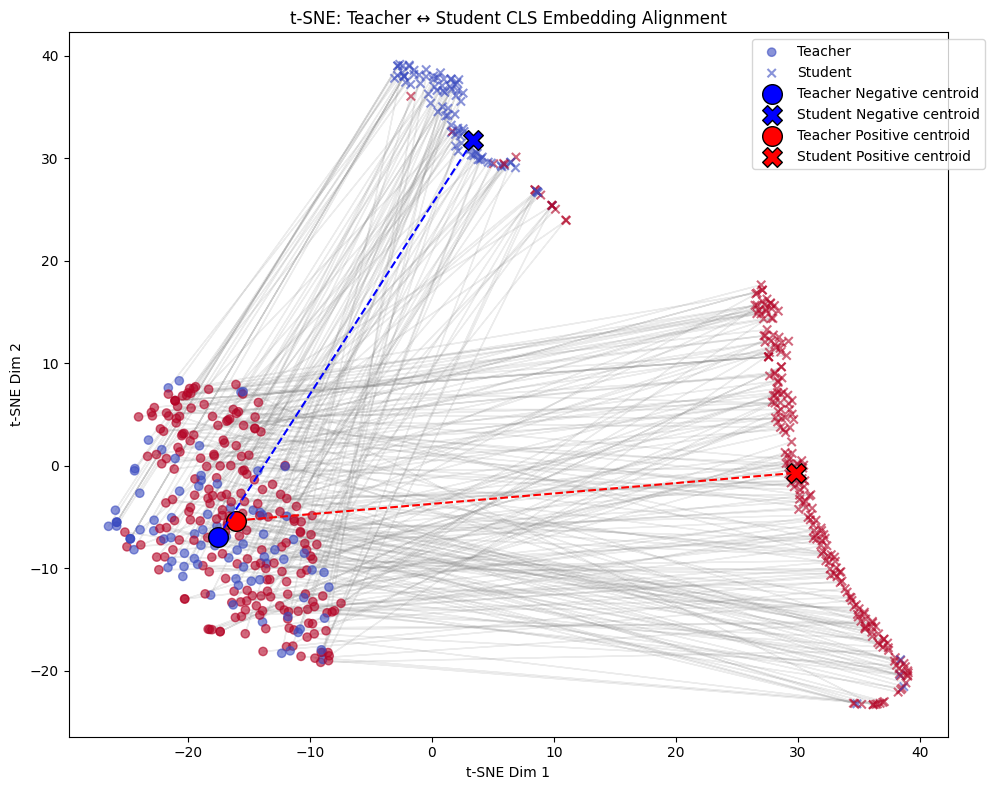

In [26]:
# ==============================================================
# 🧠 Enhanced t-SNE Visualization: Teacher ↔ Student Alignment
# ==============================================================

import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

teacher.eval()
student.eval()

# --- Sample subset from validation dataset ---
num_samples = 300  # reduce to 300 for readability
subset = random.sample(list(dataset["validation"]), k=min(num_samples, len(dataset["validation"])))
texts = [ex["text"] for ex in subset]
labels = np.array([ex["labels"] for ex in subset])
print(f"Visualizing {len(texts)} samples")

# --- Helper to extract CLS embeddings ---
def extract_cls_embeddings(model, tokenizer, texts, max_len=cfg.max_length):
    embs = []
    for i in range(0, len(texts), cfg.eval_batch_size):
        batch = texts[i : i + cfg.eval_batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(cfg.device)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
            cls = out.hidden_states[-1][:, 0, :].detach().cpu().numpy()
        embs.append(cls)
    return np.concatenate(embs, axis=0)

print("Extracting teacher embeddings ...")
teacher_embs = extract_cls_embeddings(teacher, teacher_tokenizer, texts)
print("Extracting student embeddings ...")
student_embs = extract_cls_embeddings(student, student_tokenizer, texts)

# --- Run t-SNE on concatenated features ---
print("Running t-SNE (≈1–2 min) ...")
all_embs = np.concatenate([teacher_embs, student_embs], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=2000)
all_2d = tsne.fit_transform(all_embs)

n = len(texts)
teacher_2d, student_2d = all_2d[:n], all_2d[n:]

# --- Compute centroids for each class ---
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# --- Plot ---
plt.figure(figsize=(10,8))

# Arrows teacher→student
for i in range(n):
    plt.arrow(
        teacher_2d[i,0], teacher_2d[i,1],
        student_2d[i,0] - teacher_2d[i,0],
        student_2d[i,1] - teacher_2d[i,1],
        color="gray", alpha=0.15, head_width=0.0, length_includes_head=True
    )

# Teacher points
plt.scatter(teacher_2d[:,0], teacher_2d[:,1],
            c=labels, cmap="coolwarm", marker="o", alpha=0.6, label="Teacher")
# Student points
plt.scatter(student_2d[:,0], student_2d[:,1],
            c=labels, cmap="coolwarm", marker="x", alpha=0.6, label="Student")

# Centroids
for label, color, name in [(0, "blue", "Negative"), (1, "red", "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    plt.scatter(*t_c, color=color, edgecolor="k", s=200, marker="o", label=f"Teacher {name} centroid")
    plt.scatter(*s_c, color=color, edgecolor="k", s=200, marker="X", label=f"Student {name} centroid")
    plt.plot([t_c[0], s_c[0]], [t_c[1], s_c[1]], color=color, linestyle="--", linewidth=1.5)

plt.title("t-SNE: Teacher ↔ Student CLS Embedding Alignment")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.show()


# Centroid & Cluster Similarity Analysis

In [27]:
# ==============================================================
# 📊 Centroid and Cluster Similarity Analysis
# ==============================================================

from scipy.spatial.distance import cosine, euclidean

# Compute centroids again (if not already defined)
centroids = {}
for label in np.unique(labels):
    centroids[(label, "teacher")] = teacher_2d[labels == label].mean(axis=0)
    centroids[(label, "student")] = student_2d[labels == label].mean(axis=0)

# Helper to compute dispersion (cluster spread)
def cluster_dispersion(points, centroid):
    return np.mean([euclidean(p, centroid) for p in points])

results = []

for label, name in [(0, "Negative"), (1, "Positive")]:
    t_c = centroids[(label, "teacher")]
    s_c = centroids[(label, "student")]
    
    cos_sim = 1 - cosine(t_c, s_c)
    euc_dist = euclidean(t_c, s_c)
    
    t_disp = cluster_dispersion(teacher_2d[labels == label], t_c)
    s_disp = cluster_dispersion(student_2d[labels == label], s_c)
    
    results.append({
        "Label": name,
        "Centroid Cosine Sim": cos_sim,
        "Centroid Distance": euc_dist,
        "Teacher Spread": t_disp,
        "Student Spread": s_disp
    })

pd.DataFrame(results)


,Label,Centroid Cosine Sim,Centroid Distance,Teacher Spread,Student Spread
0,Negative,-0.466437,44.083073,6.704476,7.800887
1,Positive,-0.941156,46.090630,7.844745,13.275410
